In [1]:
!pip install pandas numpy matplotlib seaborn plotly
!pip install xgboost

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import plotly.express as px
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support as score, roc_curve
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate
from sklearn.utils import compute_sample_weight
from xgboost import XGBClassifier

# load the train data using a raw string literal for the path
path = r'C:\Users\ASUS\Desktop\motor-prediction\prediction_jupyter_my-file-original\predictive_maintenance.csv'
df = pd.read_csv(path)

# define the target
target_name = 'Failure Type'

# drop a redundant column
df.drop(columns=['Target'], inplace=True)

# print a summary of the train data
print(df.shape[0])
df.head(3)

10000


UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min] Failure Type  
0                    1551         42.8                0   No Failure  
1                    1408         46.3                3   No Failure  
2                    1498         49.4                5   No Failure

In [3]:
# check for missing values
def print_missing_values(df):
    null_df = pd.DataFrame(df.isna().sum(), columns=['null_values']).sort_values(['null_values'], ascending=False)
    fig = plt.subplots(figsize=(16, 6))
    ax = sns.barplot(data=null_df, x='null_values', y=null_df.index, color='royalblue')
    pct_values = [' {:g}'.format(elm) + ' ({:.1%})'.format(elm/len(df)) for elm in list(null_df['null_values'])]
    ax.set_title('Overview of missing values')
    ax.bar_label(container=ax.containers[0], labels=pct_values, size=12)

if df.isna().sum().sum() > 0:
    print_missing_values(df)
else:
    print('no missing values')

# drop all columns with more than 5% missing values
for col_name in df.columns:
    if df[col_name].isna().sum()/df.shape[0] > 0.05:
        df.drop(columns=[col_name], inplace=True) 

df.columns


no missing values


Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Failure Type'],
      dtype='object')

In [4]:
# drop id columns
df_base = df.drop(columns=['Product ID', 'UDI'])

# adjust column names
df_base.rename(columns={'Air temperature [K]': 'air_temperature', 
                        'Process temperature [K]': 'process_temperature', 
                        'Rotational speed [rpm]':'rotational_speed', 
                        'Torque [Nm]': 'torque', 
                        'Tool wear [min]': 'tool_wear'}, inplace=True)
df_base.head()

Type  air_temperature  process_temperature  rotational_speed  torque  \
0    M            298.1                308.6              1551    42.8   
1    L            298.2                308.7              1408    46.3   
2    L            298.1                308.5              1498    49.4   
3    L            298.2                308.6              1433    39.5   
4    L            298.2                308.7              1408    40.0   

   tool_wear Failure Type  
0          0   No Failure  
1          3   No Failure  
2          5   No Failure  
3          7   No Failure  
4          9   No Failure

In [5]:
# display class distribution of the target variable
px.histogram(df_base, y="Failure Type", color="Failure Type") 

C:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



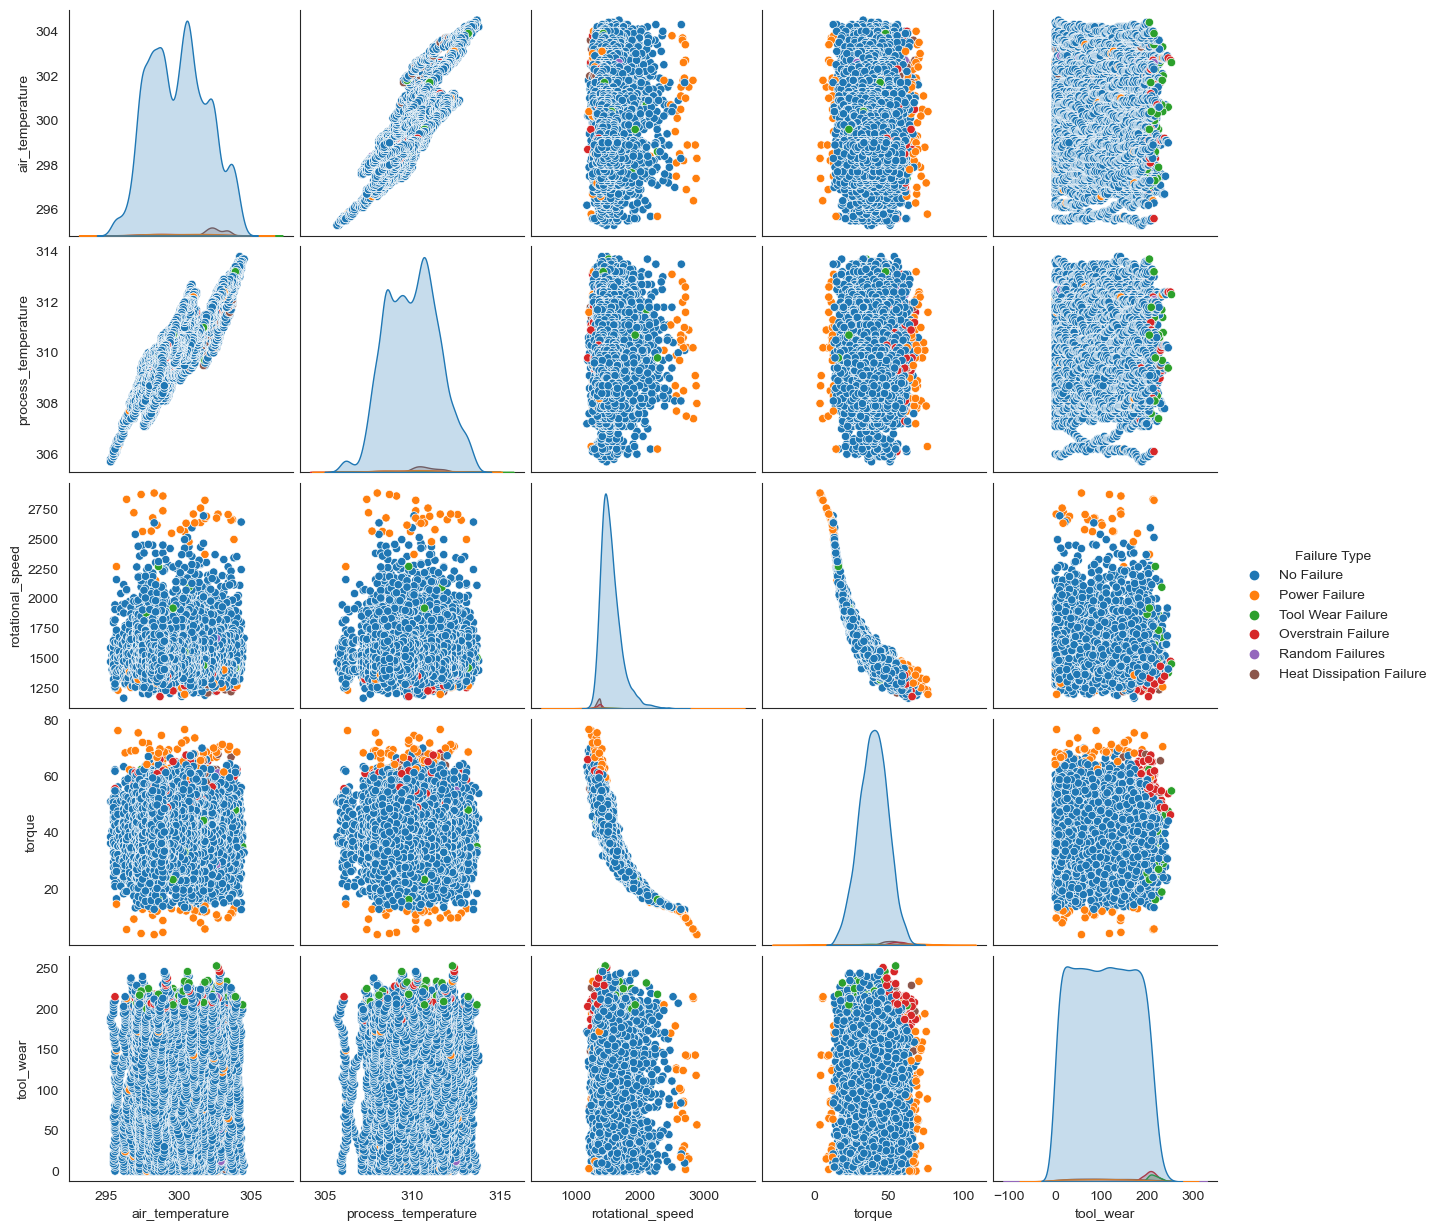

In [6]:
# pairplots on failure type
sns.pairplot(df_base, height=2.5, hue='Failure Type')

In [7]:
# Step 1: Ensure Proper Dropping
# Check if 'UDI' and 'Product ID' columns are dropped properly
if 'UDI' in df_base.columns or 'Product ID' in df_base.columns:
    df_base.drop(columns=['UDI', 'Product ID'], inplace=True)
    print("Columns 'UDI' and 'Product ID' dropped successfully.")
else:
    print("Columns 'UDI' and 'Product ID' were already dropped or not present.")

# Step 2: Verify Column Types
# Print column types to verify numeric types
print("\nColumn types:")
print(df_base.dtypes)

# Step 3: Column Renaming Check
# Ensure column renaming did not introduce unexpected string values
expected_columns = ['Type', 'air_temperature', 'process_temperature', 'rotational_speed', 'torque', 'tool_wear', 'Failure Type']
if all(col in df_base.columns for col in expected_columns):
    print("\nColumns have been renamed correctly.")
else:
    print("\nColumn renaming may not have applied correctly. Current columns:")
    print(df_base.columns)

Columns 'UDI' and 'Product ID' were already dropped or not present.

Column types:
Type                    object
air_temperature        float64
process_temperature    float64
rotational_speed         int64
torque                 float64
tool_wear                int64
Failure Type            object
dtype: object

Columns have been renamed correctly.


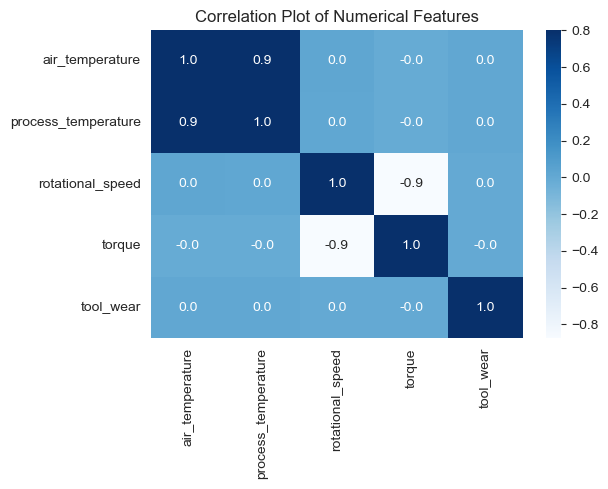

In [8]:
# Filter out categorical columns for correlation calculation
numerical_columns = df_base.select_dtypes(include=['float64', 'int64']).columns

# Correlation plot using only numerical columns
plt.figure(figsize=(6,4))
sns.heatmap(df_base[numerical_columns].corr(), cbar=True, fmt='.1f', vmax=0.8, annot=True, cmap='Blues')
plt.title('Correlation Plot of Numerical Features')
plt.show()

In [9]:
# create histograms for feature columns separated by target column
def create_histogram(column_name):
    plt.figure(figsize=(16,6))
    return px.box(data_frame=df_base, y=column_name, color='Failure Type', points="all", width=1200)

create_histogram('air_temperature')

<Figure size 1600x600 with 0 Axes>

In [10]:
create_histogram('process_temperature')

<Figure size 1600x600 with 0 Axes>

In [11]:
create_histogram('rotational_speed')

<Figure size 1600x600 with 0 Axes>

In [12]:
create_histogram('torque')

<Figure size 1600x600 with 0 Axes>

In [13]:
create_histogram('tool_wear')

<Figure size 1600x600 with 0 Axes>

In [14]:
def data_preparation(df_base, target_name):
    df = df_base.dropna()

    df['target_name_encoded'] = df[target_name].replace({'No Failure': 0, 'Power Failure': 1, 'Tool Wear Failure': 2, 'Overstrain Failure': 3, 'Random Failures': 4, 'Heat Dissipation Failure': 5})
    df['Type'].replace({'L': 0, 'M': 1, 'H': 2}, inplace=True)
    X = df.drop(columns=[target_name, 'target_name_encoded'])
    y = df['target_name_encoded'] #Prediction label

    # split the data into x_train and y_train data sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

    # print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
    print('train: ', X_train.shape, y_train.shape)
    print('test: ', X_test.shape, y_test.shape)
    return X, y, X_train, X_test, y_train, y_test

# remove target from training data
X, y, X_train, X_test, y_train, y_test = data_preparation(df_base, target_name)

train:  (7000, 6) (7000,)
test:  (3000, 6) (3000,)


In [15]:
weight_train = compute_sample_weight('balanced', y_train)
weight_test = compute_sample_weight('balanced', y_test)

xgb_clf = XGBClassifier(booster='gbtree', 
                        tree_method='gpu_hist', 
                        sampling_method='gradient_based', 
                        eval_metric='aucpr', 
                        objective='multi:softmax', 
                        num_class=6)
# fit the model to the data
xgb_clf.fit(X_train, y_train.ravel(), sample_weight=weight_train)

C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning:

[00:06:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"




XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=6,
              num_parallel_tree=None, ...)

In [16]:
# score the model with the test dataset
score = xgb_clf.score(X_test, y_test.ravel(), sample_weight=weight_test)

# predict on the test dataset
y_pred = xgb_clf.predict(X_test)

# print a classification report
results_log = classification_report(y_test, y_pred)
print(results_log)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2903
           1       0.64      0.88      0.74        24
           2       0.04      0.08      0.06        12
           3       0.77      0.89      0.83        27
           4       0.00      0.00      0.00         4
           5       0.76      0.97      0.85        30

    accuracy                           0.98      3000
   macro avg       0.53      0.63      0.58      3000
weighted avg       0.98      0.98      0.98      3000



C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning:

[00:06:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"


C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning:

[00:06:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for boost

<Axes: xlabel='Predicted', ylabel='Actual'>

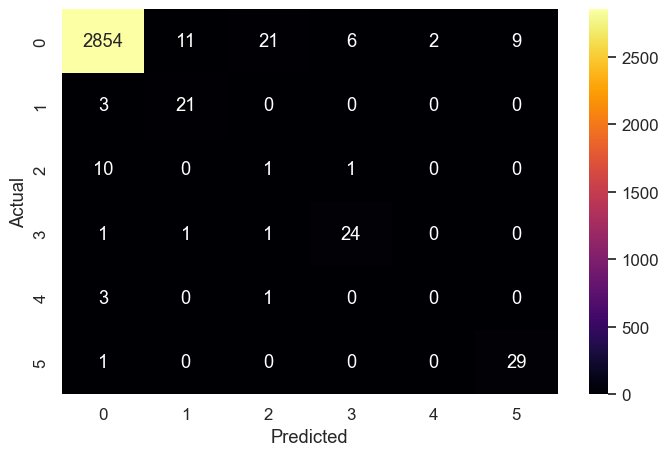

In [17]:
# create predictions on the test dataset
y_pred = xgb_clf.predict(X_test)

# print a multi-Class Confusion Matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cnf_matrix, columns=np.unique(y_test), index=np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (8, 5))
sns.set(font_scale=1.1) #for label size
sns.heatmap(df_cm, cbar=True, cmap= "inferno", annot=True, fmt='.0f') 

In [18]:
# cross validation
scores  = cross_validate(xgb_clf, X_train, y_train, cv=10, scoring="f1_weighted", fit_params={ "sample_weight" :weight_train})
scores_df = pd.DataFrame(scores)
px.bar(x=scores_df.index, y=scores_df.test_score, width=800)

C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning:

[00:06:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"


C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning:

[00:06:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"


C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning:

[00:06:23] WARNING: C:\buildkite-agent\builds\bu

In [19]:
import joblib

# Save the model
joblib_file = "xgb_model.pkl"  
joblib.dump(xgb_clf, joblib_file)

['xgb_model.pkl']

In [20]:
import joblib

# Load the model
xgb_clf = joblib.load("xgb_model.pkl")

In [21]:
import pandas as pd
import numpy as np
import joblib

# Load the trained model
xgb_clf = joblib.load("xgb_model.pkl")

# Hardcode input values
def get_manual_input():
    data = {}
    data['Type'] = 'L'  # Change this value to 'L', 'M', or 'H'
    data['air_temperature'] = 298.8  # Example value, change as needed
    data['process_temperature'] = 308.9  # Example value, change as needed
    data['rotational_speed'] = 1455.0  # Example value, change as needed
    data['torque'] = 41.3  # Example value, change as needed
    data['tool_wear'] = 208.0  # Example value, change as needed
    data['Type'] = {'L': 0, 'M': 1, 'H': 2}[data['Type']]
    return data

# Prepare the input data
def prepare_manual_input(data):
    df_manual = pd.DataFrame([data])
    expected_columns = ['Type', 'air_temperature', 'process_temperature', 'rotational_speed', 'torque', 'tool_wear']
    for col in expected_columns:
        if col not in df_manual.columns:
            df_manual[col] = np.nan
    return df_manual

# Input values manually
manual_data = get_manual_input()
X_manual = prepare_manual_input(manual_data)

# Perform prediction
y_manual_pred = xgb_clf.predict(X_manual)

# Convert prediction results to meaningful labels
label_mapping = {0: 'No Failure', 1: 'Power Failure', 2: 'Tool Wear Failure', 3: 'Overstrain Failure', 4: 'Random Failures', 5: 'Heat Dissipation Failure'}
predicted_label = label_mapping[y_manual_pred[0]]

# Print predictions
print(f"The predicted failure type is: {predicted_label}")

The predicted failure type is: Tool Wear Failure


C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning:

[00:06:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"




In [22]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)

# Train the model
rf_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_clf.predict(X_test)

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2903
           1       0.87      0.83      0.85        24
           2       0.00      0.00      0.00        12
           3       0.82      0.52      0.64        27
           4       0.00      0.00      0.00         4
           5       0.92      0.73      0.81        30

    accuracy                           0.98      3000
   macro avg       0.60      0.51      0.55      3000
weighted avg       0.98      0.98      0.98      3000



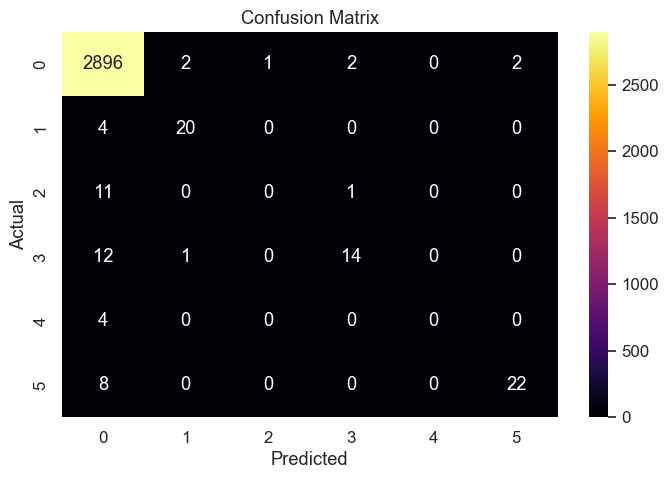

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Print the classification report
results_log = classification_report(y_test, y_pred)
print(results_log)

# Create and plot a confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cnf_matrix, columns=np.unique(y_test), index=np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize=(8, 5))
sns.set(font_scale=1.1)  # for label size
sns.heatmap(df_cm, cbar=True, cmap="inferno", annot=True, fmt='.0f')
plt.title('Confusion Matrix')
plt.show()

In [24]:
import joblib

# Save the model to a file
joblib_file = "rf_model.pkl"
joblib.dump(rf_clf, joblib_file)

['rf_model.pkl']

In [25]:
import joblib

# Load the model from the file
rf_clf = joblib.load("rf_model.pkl")

In [26]:
from sklearn.metrics import accuracy_score

# Load the XGBoost model
xgb_clf = joblib.load("xgb_model.pkl")

# Evaluate XGBoost model
y_pred_xgb = xgb_clf.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb:.4f}")

# Load the Random Forest model
rf_clf = joblib.load("rf_model.pkl")

# Evaluate Random Forest model
y_pred_rf = rf_clf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")

# Compare the accuracy of both models
if accuracy_xgb > accuracy_rf:
    print(f"XGBoost is better with accuracy: {accuracy_xgb:.4f}")
elif accuracy_rf > accuracy_xgb:
    print(f"Random Forest is better with accuracy: {accuracy_rf:.4f}")
else:
    print(f"Both models have the same accuracy: {accuracy_xgb:.4f}")

C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning:

[00:06:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"




XGBoost Accuracy: 0.9763
Random Forest Accuracy: 0.9840
Random Forest is better with accuracy: 0.9840


In [27]:
import pandas as pd
import joblib
import numpy as np

# Function to load the new data
def load_data(file_path):
    if file_path.endswith('.csv'):
        return pd.read_csv(file_path)
    elif file_path.endswith('.xlsx'):
        return pd.read_excel(file_path)
    else:
        raise ValueError("Unsupported file format. Please provide a CSV or Excel file.")

# Adjust column names to match the training data
def preprocess_data(df):
    df.rename(columns={'Air temperature [K]': 'air_temperature', 
                       'Process temperature [K]': 'process_temperature', 
                       'Rotational speed [rpm]':'rotational_speed', 
                       'Torque [Nm]': 'torque', 
                       'Tool wear [min]': 'tool_wear'}, inplace=True)
    
    df['Type'].replace({'L': 0, 'M': 1, 'H': 2}, inplace=True)

    # Ensure the new data has the correct columns
    expected_columns = ['Type', 'air_temperature', 'process_temperature', 'rotational_speed', 'torque', 'tool_wear']
    for col in expected_columns:
        if col not in df.columns:
            df[col] = np.nan

    return df[expected_columns]

# Function to make predictions
def make_predictions(df):
    # Load the trained models
    xgb_clf = joblib.load("xgb_model.pkl")
    rf_clf = joblib.load("rf_model.pkl")

    # Predict with XGBoost
    xgb_predictions = xgb_clf.predict(df)

    # Predict with Random Forest
    rf_predictions = rf_clf.predict(df)

    # Convert prediction results to meaningful labels
    label_mapping = {0: 'No Failure', 1: 'Power Failure', 2: 'Tool Wear Failure', 3: 'Overstrain Failure', 4: 'Random Failures', 5: 'Heat Dissipation Failure'}
    xgb_predicted_labels = [label_mapping[pred] for pred in xgb_predictions]
    rf_predicted_labels = [label_mapping[pred] for pred in rf_predictions]

    return xgb_predicted_labels, rf_predicted_labels

# Main function to load data, preprocess, and make predictions
def main(file_path):
    new_df = load_data(file_path)
    processed_df = preprocess_data(new_df)
    xgb_predicted_labels, rf_predicted_labels = make_predictions(processed_df)

    # Create a DataFrame with the predictions
    predictions_df = new_df.copy()
    predictions_df['XGB_Predicted_Failure_Type'] = xgb_predicted_labels
    predictions_df['RF_Predicted_Failure_Type'] = rf_predicted_labels

    # Save the predictions to a new CSV file
    predictions_df.to_csv('Sensor_Data_predictions_with_failure_type.csv', index=False)
    print("Sensor_Data_predictions_with_failure_type.csv")

# Example usage
file_path = r"C:\Users\ASUS\Desktop\motor-prediction\prediction_jupyter_my-file-original\Sensor_Data.csv"  # Replace with your file path
main(file_path)


Sensor_Data_predictions_with_failure_type.csv


C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning:

[00:06:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"


